# Taux de désabonnement des clients d'une entreprise

## Importation et traitement du jeu de donnée 

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [62]:
data = pd.read_csv('data.csv')

In [63]:
data.head()

,num_ligne,ID_Client,Nom,Score_Credit,Pays,Sex,Age,Tenure,Balance,Num_Produit,il_a_CrCard,Membre_actif,Salaire_estime,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [64]:
# Vérifier si des nan son présents
data.isnull().sum()

num_ligne         0
ID_Client         0
Nom               0
Score_Credit      0
Pays              0
Sex               0
Age               0
Tenure            0
Balance           0
Num_Produit       0
il_a_CrCard       0
Membre_actif      0
Salaire_estime    0
Exited            0
dtype: int64

In [65]:
y = data.Exited.values
print("Il y a {} valeurs uniques".format(len(np.unique(y))))

Il y a 2 valeurs uniques


In [66]:
data = data.drop(['num_ligne', 'ID_Client', 'Nom'], axis=1)
data.head()

,Score_Credit,Pays,Sex,Age,Tenure,Balance,Num_Produit,il_a_CrCard,Membre_actif,Salaire_estime,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [67]:
#Encoder les valeus qualitatives
encoder = LabelEncoder()
data['Sex'] = encoder.fit_transform(data['Sex'])
data = pd.get_dummies(data)
data.head()

,Score_Credit,Sex,Age,Tenure,Balance,Num_Produit,il_a_CrCard,Membre_actif,Salaire_estime,Exited,Pays_France,Pays_Germany,Pays_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,1,0,0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,502,0,42,8,159660.80,3,1,0,113931.57,1,1,0,0
3,699,0,39,1,0.00,2,0,0,93826.63,0,1,0,0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0,0,1


In [68]:
#Drop la target afin de définir X
X = data.drop('Exited',axis=1).values
X.shape

(10000, 12)

In [69]:
#Séparer le code en base de test et d'apprentissage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Test de l'apprentissage avec différentes méthodes
## Regression logistique :

In [70]:
clf = LogisticRegression()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
score = metrics.accuracy_score(y_test,y_pred)
print("L'accuracy est de : {}".format(score))

L'accuracy est de : 0.7915


In [71]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score = metrics.accuracy_score(y_test,y_pred)
print("L'accuracy est de : {}".format(score))

L'accuracy est de : 0.8


In [72]:
import tensorflow as tf 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [73]:
#Multiplier la taille du jeu de données par 5 afin d'améliorer les résultats
for i in range(5):
  X_train = np.concatenate((X_train,X_train),axis=0)
  y_train = np.concatenate((y_train,y_train),axis=0)

In [74]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32,activation='relu',input_shape=(12,)),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])  

In [75]:
model.fit(X_train,y_train,epochs=3, batch_size=100, validation_data=(X_test, y_test)) 

Epoch 1/3
2560/2560 [==============================] - 5s 2ms/step - loss: 0.3774 - accuracy: 0.8439 - val_loss: 0.3408 - val_accuracy: 0.8565
Epoch 2/3
2560/2560 [==============================] - 6s 2ms/step - loss: 0.3122 - accuracy: 0.8703 - val_loss: 0.3379 - val_accuracy: 0.8655
Epoch 3/3
2560/2560 [==============================] - 4s 2ms/step - loss: 0.2943 - accuracy: 0.8777 - val_loss: 0.3449 - val_accuracy: 0.8640


L'accuracy est de : 0.864


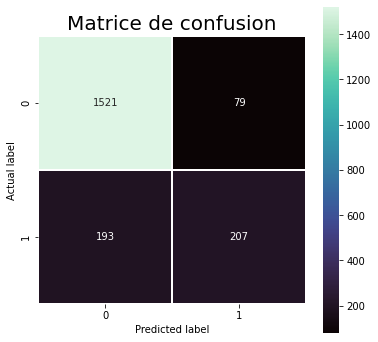

In [76]:
import seaborn as sns

y_pred = model.predict_classes(X_test)
score = metrics.accuracy_score(y_test,y_pred)
print("L'accuracy est de : {}".format(score))

cm = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='mako')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title("Matrice de confusion", size=20)
plt.show()